# **MR PREPROCESSING PIPELINE**

In [1]:
import os
import json
import ants
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt

from pathlib import Path
from concurrent.futures import ProcessPoolExecutor

from preprocessing.utils import *
from preprocessing.functions import *
from intensity_normalization.plot.histogram import HistogramPlotter

2023-08-09 12:14:47.561963: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-09 12:14:48.112558: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# !nvidia-smi
# !nvcc --version

In [3]:
# !pip install antspynet
# !pip install intensity-normalization

In [4]:
# DATA_DIR = '/mnt/c/Users/sergio/Desktop/Sergio/pydicom2niix/data'

In [5]:
IMG_DIR = 'images'
GM_ROOT = '/mnt/c/Users/sergio/Desktop/TFG/GM'
UCSF_ROOT = '/mnt/c/Users/sergio/Desktop/TFG/TCIA'

In [6]:
GM_DIR_SpN = f'{GM_ROOT}/GM-SpN'  # Spatial Normalization
GM_DIR_SkS = f'{GM_ROOT}/GM-SkS'  # Skull Stripped
GM_DIR_BFC_DN = f'{GM_ROOT}/GM-BFC+DN'  # Bias Field Correction + Denoise
GM_DIR_HM = f'{GM_ROOT}/GM-HM'  # Histogram matched
GM_DIR_HM_NORM = f'{GM_ROOT}/GM-HM+NORM'  # Histogram matched + Normalized
GM_DIR_NORM = f'{GM_ROOT}/GM-NORM'  # Normalized

GM_DIR_BFC_DN_NORM = f'{GM_ROOT}/GM-BFC+DN+NORM_WS'

In [7]:
GM_BRATS = f'{GM_ROOT}/GM-BRATS'  # BraTS Pre-Processing Pipeline
GM_BRATS_NORM = f'{GM_ROOT}/GM-BRATS+NORM_WS'  # BraTS Pre-Processing Pipeline + Normalization
GM_BRATS_NORM = f'{GM_ROOT}/GM-BRATS+NORM_FCM'

In [8]:
UCSF_BASE = f'{UCSF_ROOT}/UCSF-CLEANED'
UCSF_NORM = f'{UCSF_ROOT}/UCSF-NORM'

In [9]:
def plot_histograms(images, title, masks=None, figsize=(10, 5)):
    hist = HistogramPlotter(figsize=figsize)
    hist.plot_all_histograms(images, masks=masks)
    plt.title(title, fontweight='bold', y=1.02)

In [10]:
norm_method = 'WhiteStripe'
NORM_FOLDER = GM_DIR_BFC_DN_NORM

## **T1w**

In [11]:
# gm_t1w_imgs = load_images(GM_DIR_SpN, modality='T1w')

In [12]:
# plot_histograms(gm_t1w_imgs, 'Histograms of T1-w Images\nwithout Intensity Normalization', )
# plt.savefig(f'{IMG_DIR}/T1w/T1w_hist_not_norm_SpN.png', bbox_inches='tight')
# plt.show()

In [13]:
# gm_t1w_imgs = load_images(GM_BRATS, modality='T1w')

In [14]:
# plot_histograms(gm_t1w_imgs, f'Histograms of T1-w Images\nwithout Intensity Normalization (after BraTS)')
# plt.savefig(f'{IMG_DIR}/T1w/T1w_hist_not_norm_BraTS', bbox_inches='tight')
# plt.show()

In [15]:
# gm_t1w_imgs = load_images(NORM_FOLDER, modality='T1w')

In [16]:
# plot_histograms(gm_t1w_imgs, f'Histograms of T1-w Images\nwith Intensity Normalization ({norm_method})')
# plt.savefig(f'{IMG_DIR}/T1w/T1w_hist_norm_{norm_method.lower()}_BFC', bbox_inches='tight')
# plt.show()

## **T1w + contrast**

In [17]:
# gm_t1w_ce_imgs = load_images(GM_DIR_SpN, modality='T1w_ce')

In [18]:
# plot_histograms(gm_t1w_ce_imgs, 'Histograms of T1-w + Contrast Images\nwithout Intensity Normalization')
# plt.savefig(f'{IMG_DIR}/T1w_ce/T1w_ce_hist_not_norm_SpN.png', bbox_inches='tight')
# plt.show()

In [19]:
# gm_t1w_ce_imgs = load_images(NORM_FOLDER, modality='T1w_ce')

In [20]:
# plot_histograms(gm_t1w_ce_imgs, f'Histograms of T1-w + Contrast Images\nwith Intensity Normalization ({norm_method})')
# plt.savefig(f'{IMG_DIR}/T1w_ce/T1w_ce_hist_norm_{norm_method.lower()}_BFC.png', bbox_inches='tight')
# plt.show()

## **FLAIR**

In [21]:
# gm_flair_imgs = load_images(GM_DIR_SpN, modality='FLAIR')

In [22]:
# plot_histograms(gm_flair_imgs, 'Histograms of FLAIR Images\nwithout Intensity Normalization')
# plt.savefig(f'{IMG_DIR}/FLAIR/FLAIR_hist_not_norm_SpN.png', bbox_inches='tight')
# plt.show()

In [23]:
gm_flair_imgs = load_images(NORM_FOLDER, modality='FLAIR')

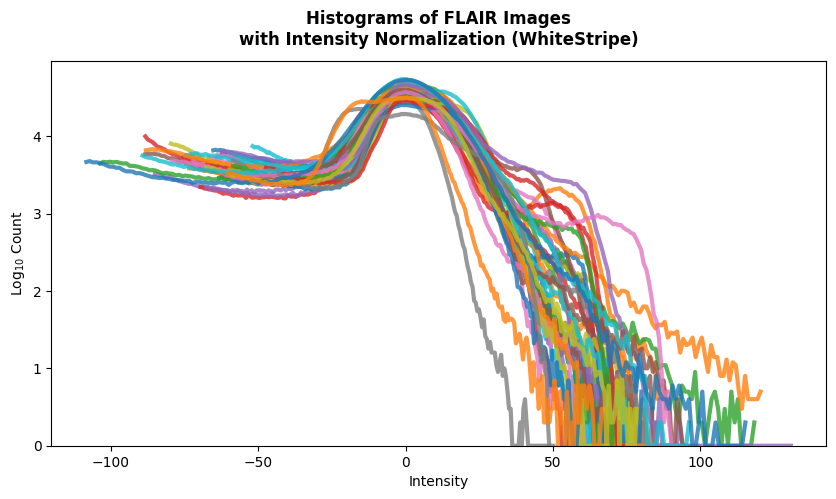

In [24]:
plot_histograms(gm_flair_imgs, f'Histograms of FLAIR Images\nwith Intensity Normalization ({norm_method})')
plt.savefig(f'{IMG_DIR}/FLAIR/FLAIR_hist_norm_{norm_method.lower()}.png', bbox_inches='tight')
plt.show()

## **INTENSITY COMPARISON**

In [25]:
def compare_intensities(img_series, title, figsize=(8, 4), labels=["UCSF", "GM"], step=1000, closest_hundred=3, log=False):
    fig, ax = plt.subplots(figsize=figsize)

    if log:
        plt.yscale('log')
    
    ax.boxplot(img_series, labels=labels)

    ax.set_title(title, fontweight='bold')
    ax.set_ylabel("Intensity")
    ax.yaxis.grid(True, linestyle='-', which='major', color='lightgrey')
    min_ = np.floor(min(map(min, img_series)) / 10**closest_hundred) * 10**closest_hundred
    max_ = np.ceil(max(map(max, img_series)) / 10**closest_hundred) * 10**closest_hundred

    ax.set_ylim([min_, max_])
    ax.set_yticks(np.arange(min_, max_, step))
    
    plt.show()

## **T1w**
|              | UCSF      | GM       | UCSF Patient | GM Patient |
|--------------|-----------|----------|--------------|------------|
| **MEAN**     | 276.00    | 274.45   | ----------   | ---------- |
| **VAR**      | 491109.11 | 181038.0 | ----------   | ---------- |
| **Min MIN**  | 0.0       | -200.04  | ----------   | sub-0028   |
| **Max MIN**  | 0.0       | -56.46   | ----------   | sub-0020   |
| **Min MAX**  | 335.94    | 2290.8   | sub-0435     | sub-0028   |
| **Mean MAX** | 2994.74   | 5901.71  | ----------   | ---------- |
| **Max MAX**  | 8689.24   | 6696.9   | sub-0458     | sub-0023   |

## **T1w after Processing**
|              | UCSF     | GM after Bias Corr. |
|--------------|----------|---------------------|
| **MEAN**     | 305.47   | 342.16              |
| **VAR**      | 606012.7 | 670861.25           |
| **Min MIN**  | 0.0      | 0.0                 |
| **Max MIN**  | 0.0      | 0.0                 |
| **Min MAX**  | 538.81   | 3064.15             |
| **Mean MAX** | 4635.03  | 5901.71             |
| **Max MAX**  | 13308.66 | 11134.33            |

In [ ]:
t1w_ucsf = show_series_info('T1w', f'{UCSF_ROOT}/UCSF_metadata.json')
t1w_gm_sn = show_series_info('T1w', f'{GM_ROOT}/GM_spatial_norm.json')
t1w_gm_brats = show_series_info('T1w', f'{GM_ROOT}/GM_after_BraTS.json')
# t1w_gm_hm = show_series_info('T1w', f'{GM_ROOT}/GM_histogram_match.json')

compare_intensities(
    [t1w_ucsf, t1w_gm_sn, t1w_gm_brats],#, t1w_gm_hm],
    title="T1-weighted\nUCSF and GM intensities",
    labels=['UCSF', 'GM after\nSpatial Norm.', 'GM after\nBraTS Pre-Processing']#, 'GM after\nHistogram Matching']
)

In [ ]:
t1w_ucsf_norm = show_series_info('T1w', f'{UCSF_ROOT}/UCSF_normalized.json')
t1w_gm_norm = show_series_info('T1w', f'{GM_ROOT}/GM_BraTS_with_normalization.json')
# t1w_gm_hm_norm = show_series_info('T1w', f'{GM_ROOT}/GM_histogram_match_normalization.json')

compare_intensities(
    [t1w_ucsf_norm, t1w_gm_norm],#, t1w_gm_hm_norm],
    title="T1-weighted\nUCSF and GM intensities", closest_hundred=2, step=100,
    labels=['UCSF after\nNormalization', 'GM after\nNormalization']#, 'GM after\nHist. Match. + Normalization'],
)

## **T1w + contrast**
|              | UCSF      | GM        | UCSF Patient | GM Patient |
|--------------|-----------|-----------|--------------|------------|
| **MEAN**     | 424.30    | 309.82    | ----------   | ---------- |
| **VAR**      | 1344582.4 | 222400.95 | ----------   | ---------- |
| **Min MIN**  | 0.0       | -292.56   | ----------   | sub-0036   |
| **Max MIN**  | 0.0       | -48.58    | ----------   | sub-0002   |
| **Min MAX**  | 690.88    | 3956.66   | sub-0201     | sub-0014   |
| **Mean MAX** | 13266.37  | 4815.14   | ----------   | ---------- |
| **Max MAX**  | 25493.8   | 6384.92   | sub-0269     | sub-0024   |

## **T1w + contrast after Processing**
|              | UCSF      | GM after Bias Corr. |
|--------------|-----------|---------------------|
| **MEAN**     | 479.49    | 220.38              |
| **VAR**      | 1022254.29 | 299007.78           |
| **Min MIN**  | 0.0       | 0.0                 |
| **Max MIN**  | 0.0       | 0.0                 |
| **Min MAX**  | 466.15    | 1724.18             |
| **Mean MAX** | 9591.67  | 4675.14             |
| **Max MAX**  | 17117.28   | 9687.14             |

In [ ]:
t1w_ce_ucsf = show_series_info('T1w_ce', f'{UCSF_ROOT}/UCSF_metadata.json')
t1w_ce_gm_sn = show_series_info('T1w_ce', f'{GM_ROOT}/GM_spatial_norm.json')
t1w_gm_brats = show_series_info('T1w_ce', f'{GM_ROOT}/GM_after_BraTS.json')
# t1w_ce_gm_hm = show_series_info('T1w_ce', f'{GM_ROOT}/GM_histogram_match.json')

compare_intensities(
    [t1w_ce_ucsf, t1w_ce_gm_sn, t1w_gm_brats],#, t1w_ce_gm_hm],
    title="T1-weighted w/contrast\nUCSF and GM intensities", step=2000,
    labels=['UCSF', 'GM after\nSpatial Norm.', 'GM after\nBraTS Pre-Processing']#, 'GM after\nHistogram Matching']
)

In [ ]:
t1w_ce_ucsf_norm = show_series_info('T1w_ce', f'{UCSF_ROOT}/UCSF_normalized.json')
t1w_ce_gm_norm = show_series_info('T1w_ce', f'{GM_ROOT}/GM_BraTS_with_normalization.json')
# t1w_ce_gm_hm_norm = show_series_info('T1w_ce', f'{GM_ROOT}/GM_histogram_match_normalization.json')

compare_intensities(
    [t1w_ce_ucsf_norm, t1w_ce_gm_norm],#, t1w_ce_gm_hm_norm],
    title="T1-weighted w/contrast\nUCSF and GM intensities", closest_hundred=2, step=100,
    labels=['UCSF after\nNormalization', 'GM after\nNormalization']#, 'GM after\nHist. Match. + Normalization'],
)

## **FLAIR**
|              | UCSF      | GM        | UCSF Patient | GM Patient |
|--------------|-----------|-----------|--------------|------------|
| **MEAN**     | 166.52    | 267.74    | ----------   | ---------- |
| **VAR**      | 160711.06 | 196970.19 | ----------   | ---------- |
| **Min MIN**  | 0.0       | -293.56   | ----------   | sub-0032   |
| **Max MIN**  | 0.0       | -58.33    | ----------   | sub-0021   |
| **Min MAX**  | 666.81    | 2372.77   | sub-0427     | sub-0021   |
| **Mean MAX** | 2471.22   | 3144.14   | ----------   | ---------- |
| **Max MAX**  | 6354.43   | 4762.99   | sub-0420     | sub-0011   |

## **FLAIR after Processing**
|              | UCSF      | GM after Bias Corr. |
|--------------|-----------|---------------------|
| **MEAN**     | 183.13    | 202.28              |
| **VAR**      | 199910.64 | 206154.56           |
| **Min MIN**  | 0.0       | 0.0                 |
| **Max MIN**  | 0.0       | 0.0                 |
| **Min MAX**  | 895.94    | 1571.52             |
| **Mean MAX** | 3163.71   | 2317.22             |
| **Max MAX**  | 8148.07   | 2893.35             |

In [ ]:
flair_ce_ucsf = show_series_info('FLAIR', f'{UCSF_ROOT}/UCSF_metadata.json')
flair_gm_sn = show_series_info('FLAIR', f'{GM_ROOT}/GM_spatial_norm.json')
flair_gm_brats = show_series_info('FLAIR', f'{GM_ROOT}/GM_after_BraTS.json')
# flair_gm_hm = show_series_info('FLAIR', f'{GM_ROOT}/GM_histogram_match.json')

compare_intensities(
    [flair_ce_ucsf, flair_gm_sn, flair_gm_brats],#, flair_gm_hm],
    title="FLAIR\nUCSF and GM intensities",
    labels=['UCSF', 'GM after\nSpatial Norm.', 'GM after\nBraTS Pre-Processing']#, 'GM after\nHistogram Matching']
)

In [ ]:
flair_ucsf_norm = show_series_info('FLAIR', f'{UCSF_ROOT}/UCSF_normalized.json')
flair_gm_norm = show_series_info('FLAIR', f'{GM_ROOT}/GM_BraTS_with_normalization.json')
# flair_gm_hm_norm = show_series_info('FLAIR', f'{GM_ROOT}/GM_histogram_match_normalization.json')

compare_intensities(
    [flair_ucsf_norm, flair_gm_norm],#, flair_gm_hm_norm],
    title="FLAIR\nUCSF and GM intensities", closest_hundred=2, step=100,
    labels=['UCSF after\nNormalization', 'GM after\nNormalization']#, 'GM after\nHist. Match. + Normalization']
)